In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from random import randint, shuffle
# from sklearn.preprocessing import StandardScaler

import sys
from PIL import Image
import os
import cv2
import operator
from numba import jit

# Q1.  Sequential Bayesian Learning  

## Dataset

In [3]:
import scipy.io
mat_O = scipy.io.loadmat('1_data.mat')
mat_x = mat_O['x']
mat_t = mat_O['t']
# mat_x_std = StandardScaler().fit_transform(mat_x)

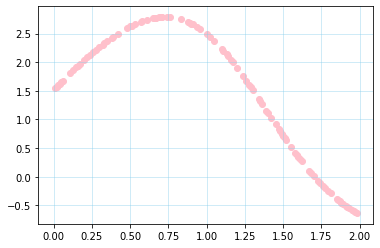

In [5]:
plt.scatter(mat_x, mat_t, c="pink")
plt.grid(alpha = 0.5, color="skyblue");


## Sigmoid Function

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [7]:
def Phi(x, M, s):
    phi = [[] for _ in range(len(x))]
    for i in range(M):
        muj = 2 * i / M
        temp = sigmoid((x - muj) / s)
        phi = np.concatenate((phi, temp), axis = 1)
    return phi

In [8]:
phi = Phi(mat_x, 3, 0.1)

$$y^T_{n\times1} = \Phi^T_{n\times n}w_{n\times1} \\ where \ n = 100$$

conjugate:  $$p(w) = N(w|0, 10^{-6}\bf{I})$$

posterior:  $$p(w|\bf{t}) = N(w|m_N, S_N)$$  
where  $$S^{-1}_N = S^{-1}_0+\beta\Phi^T\Phi$$
$$m_N = S_N\beta\Phi^T \bf{t}$$
$$\beta=1$$

[[ 1.3437174 ]
 [ 0.30335095]
 [-1.35675732]]


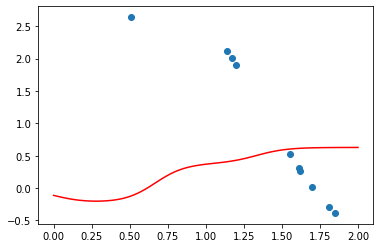

In [10]:
N = 10
s0 = (10 ** (0)) * np.eye(3)
m0 = np.zeros((3,1))
beta = 1

#initial
sn = s0
mn = m0

matx5 = mat_x[:N]
matt5 = mat_t[:N]
phi5 = Phi(matx5, 3, 0.1)

#sn, mn= np.linalg.inv(np.linalg.inv(s0) + beta*(phi.T @ phi)), \
        #sn @ (np.linalg.inv(s0) @ m0 + beta*(phi5.T @ matt5))
sn = np.linalg.inv(np.linalg.inv(s0) + beta*(phi5.T @ phi5))
mn = sn @ (np.linalg.inv(s0) @ m0 + beta*(phi5.T @ matt5))

print(mn)
w_draw = np.random.multivariate_normal(mn.flatten(), sn, None, "raise")

# define function to graph
x = np.linspace(0,2,100)
y = w_draw[0] * sigmoid((x - 0)/0.1) + \
    w_draw[1] * sigmoid((x - (2/3))/0.1) + \
    w_draw[2] * sigmoid((x - (4/3))/0.1)

# graph the result
fig = plt.figure()
plt.plot(x,y, 'r')

plt.scatter(matx5, matt5)
plt.show();

[[ 1.3437174 ]
 [ 0.30335095]
 [-1.35675732]] [[ 0.39980644 -0.3174328  -0.07817408]
 [-0.3174328   0.49687303 -0.16962524]
 [-0.07817408 -0.16962524  0.38618171]]


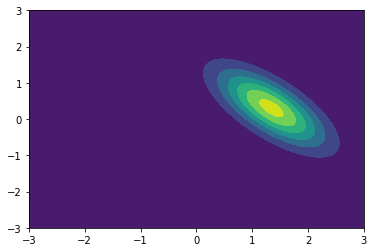

In [11]:
mu = mn[0:2]
sigma = sn[0:2, 0:2]

print(mn, sn)
def happy(x, mu, sigma):
    x_m = x - mu
    return (1. / (np.sqrt((2 * np.pi)**2 * np.linalg.det(sigma))) * \
            np.exp(-(x_m.T@np.linalg.inv(sigma)@(x_m)) / 2))

x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
pdf = np.zeros((100, 100))
for a in range(100):
    for b in range(100):
        pdf[a,b] = happy(np.matrix([[X[a,b]], [Y[a,b]]]), mu, sigma)
#Z = f(X, Y,pdf)
plt.contourf(X, Y, pdf);

# 1.  

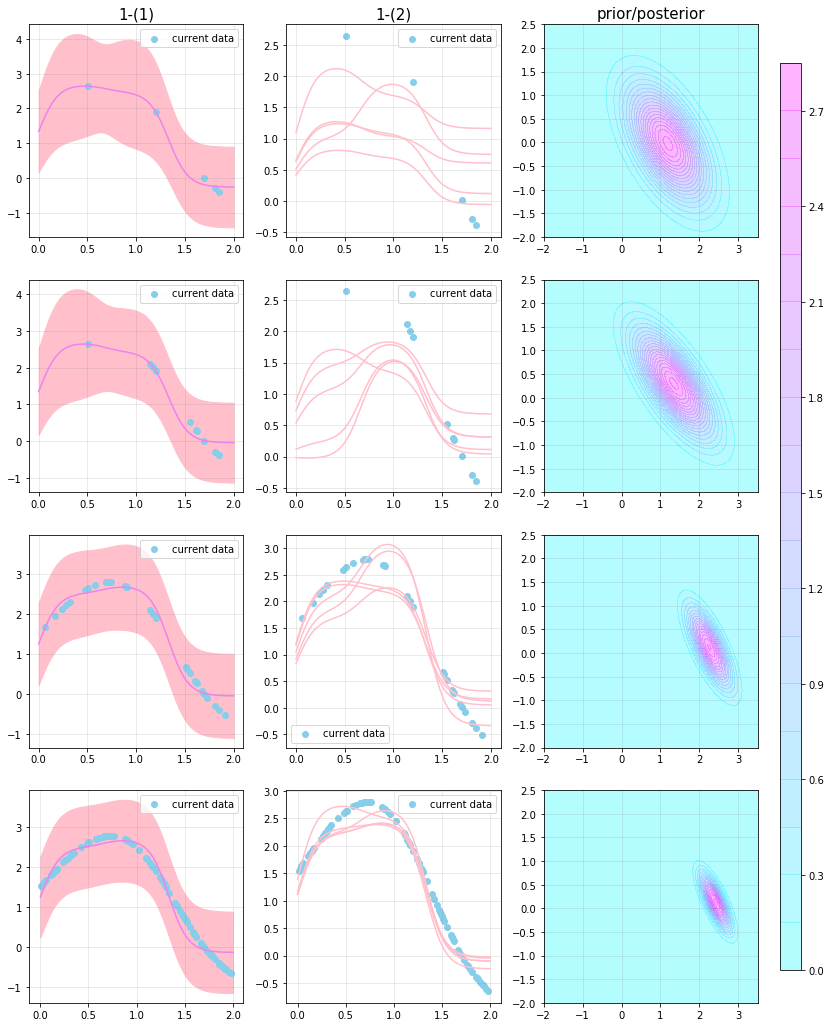

In [12]:
alpha = 10**(0)
beta = 1
s0 = alpha * np.eye(3)
m0 = np.zeros((3,1))

fig, axes = plt.subplots(4, 3, figsize=(15, 18))
N_size = [5, 10, 30, 80]

end = 0
for i in range(len(N_size)):
    start, end =end, N_size[i]
    
    matx_b = mat_x[start: end]
    matt_b = mat_t[start: end]
    phi_b = Phi(matx_b, 3, 0.1)
    
    #sn, mn= np.linalg.inv(np.linalg.inv(sn) + beta*(phi.T @ phi)), \
            #sn @ (np.linalg.inv(sn) @ mn + beta*(phi_b.T @ matt_b))
    sn = np.linalg.inv(np.linalg.inv(s0) + beta*(phi_b.T @ phi_b))
    mn = sn @ (np.linalg.inv(s0) @ m0 + beta*(phi_b.T @ matt_b))
    
    s0 = sn
    m0 = mn
    
    # 
    for j in range(5):
        w_draw = np.random.multivariate_normal(mn.flatten(), sn, None, "raise")

        # define function to graph
        x = np.linspace(0,2,100)
        y = w_draw[0] * sigmoid((x - 0)/0.1) + \
            w_draw[1] * sigmoid((x - (2/3))/0.1) + \
            w_draw[2] * sigmoid((x - (4/3))/0.1)
        
        axes[i,1].plot(x,y, 'pink')
    axes[i, 1].grid(alpha = 0.2, color="gray")
    
    # graph the current input data 
    axes[i, 1].scatter(mat_x[:end], mat_t[:end], c = 'skyblue', label = 'current data')
    axes[i, 1].legend()
    
    # graph interval
    #axes[i, 0].set_ylim(-0.5, 2.5)
    alpha_C = 10**(-6)
    matx_C = mat_x[:end]
    matt_C = mat_t[:end]
    phi_C = Phi(matx_C, 3, 0.1)
    xx = np.linspace(0, 2, 100)
    mat_xx = xx.reshape(100,-1)
    
    S = np.linalg.inv(alpha_C * np.eye(3) + beta * phi_C.T @ phi_C)
    
    mx = beta * Phi(mat_xx, 3, 0.1) @ S @ (phi_C.T @ matt_C)
    sx = np.sqrt((1 / beta) + (Phi(mat_xx, 3, 0.1) @ S @ Phi(mat_xx, 3, 0.1).T).diagonal())
    mx = mx.reshape(-1)
    sx = sx.reshape(-1)
    axes[i, 0].fill_between(xx, mx - sx, mx + sx, color="pink")
    axes[i, 0].scatter(mat_x[:end], mat_t[:end], c = 'skyblue', label = 'current data')
    axes[i, 0].legend()
    axes[i, 0].plot(xx, mx, 'violet')
    axes[i, 0].grid(alpha = 0.2, color="gray")
    
    # contour graph
    # pick w0, w1
    mu = mn[0:2]
    sigma = sn[0:2, 0:2]

    f = lambda x, mu, sigma: (1 / np.sqrt((2 * np.pi) ** 2 * np.linalg.det(sigma))) * \
        np.exp(-((x - mu).T @ np.linalg.inv(sigma) @ (x - mu)) / 2)
    
    x = np.linspace(-2, 3.5, 100)
    y = np.linspace(-2, 2.5, 100)
    X, Y = np.meshgrid(x, y)
    pdf = np.zeros((100, 100))
    for a in range(100):
        for b in range(100):
            pdf[a,b] = f(np.matrix([[X[a,b]], [Y[a,b]]]), mu, sigma)
    #Z = f(X, Y,pdf)
    cfig = axes[i, 2].contourf(X, Y, pdf, 20, cmap = 'cool', alpha = 0.3)
    axes[i, 2].grid(alpha = 0.2, color="gray")

titles = ["1-(1)", "1-(2)", "prior/posterior"]
for axi, title in zip(axes[0], titles):
    axi.set_title(title, size = 15)

# color bar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(cfig, ax = axes[i, 2], cax = cbar_ax)

#plt.savefig("foo.png")
plt.show();

# 2. Logistic  

In [3]:
with open('./Faces/Faces/s1/1.pgm', 'rb') as img:
    for i in range(4):
        line = img.readline()
        print(i, line)

0 b'P5\n'
1 b'92 112\n'
2 b'255\n'
3 b'sqqvsusurtvrrststsssturp}|~\x82\x82\x86\x7f\x8f\x7flfd\\W`XUU_aESTNIBKB?G9B?B=<OcqkSUjonoponmdtolnrmmloqkqmronnrurwsnustuuquuqsrqvssuoqlupsqtnYga\\bf^c`\\MHSMDLMA5:=>=8:7>08<TqhQUdslqokgholmropqloormmmqlpmttusstttpwsusttpttqstqshhca\\fbOT]dfhb]XLMT@=B;EG>7/,/7:)-3006<l`QW`pllqfjlsnkppntkmoppkppjqpvqsttvqtotrvquoxqtsrruokaXUFIXaeqmfTOKI9:3>=9)7.?...\' 5*+-(.1.^UPMV]Z]afkpnqmoqnpjonoommqnnourrrvuotqpvpusousrusqseQIDLIQZYb\\RSDI@782/2*;%)$5\')+"\x171"-)),(/CNFHTTQMTY_omokmqnnopqnrmnmmnlurtpuquvqvouvuutqvtnsXE<JVhwrnhm[SE>@8/,+"4)"\x1c\'\x1e#\'\x1c#\x1f\x15!\x1f/ (%%(;FETPQSLIQJ[nlpikqomrmmnoqlsjqwttvurrtqurqwqrstrpYM=?AZhtx`aZVIF>A?=7)%$!!\x1f\x16\x1e\x1f\x1d"\x1e\x1d\x1f\x15\x1e\x1e*) ##$4GCMTTWVXZKHYonpppqlqjponlqqnoutvsutqstuovsxtswjG8=?RW\\\\beXNBE4.%)%$/#.\'\x1c"\x18"\x10\x1c#\x1e\x19\x17\x1a\x13\x1f#&.\x17(\x1e\x1b+9EIZ\\bXe^`UIYlmlquiqnkmnjopoqvtsvsvqvvrpustrqiL:6NDE>KOYURD:6*&"\x1c\x1a\x18\x17\x17\x1f\x1a\x1f\x1e\x17\x1f\x17 \x1f#\x1e\x1b\x18

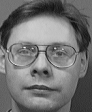

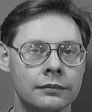

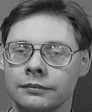

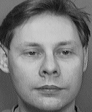

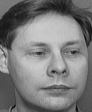

In [4]:
for i in range(1, 6):
    Image.open('./Faces/Faces/s1/{}.pgm'.format(i))

In [3]:
def oneHot(x):
    return np.array(pd.get_dummies(pd.Series(x.reshape(-1))))

In [4]:
def softmax(ak):
    return np.exp(ak) / np.exp(ak).sum(axis = 1)[:, None]

In [5]:
def get_data():
    order = [x for x in range(1, 11)]
    shuffle(order)
    print(order)

    global train_2, train_t, test_2, test_t
    
    train_2 = []
    test_2 = []
    train_t = []
    test_t = []
    for i in range(1, 6):
        for j in order[:5]:
            train_2.append(cv2.imread('./Faces/Faces/s{}/{}.pgm'.format(i, j), 0))
            train_t.append([i])
        for k in order[5:]:
            test_2.append(cv2.imread('./Faces/Faces/s{}/{}.pgm'.format(i, k), 0))
            test_t.append([i])

    train_2 = np.array(train_2).reshape(25, -1) / 255
    test_2 = np.array(test_2).reshape(25, -1) / 255

    train_t = oneHot(np.array(train_t).reshape(25, -1))
    test_t = oneHot(np.array(test_t).reshape(25, -1))

In [8]:
get_data()

[10, 7, 5, 3, 8, 1, 4, 6, 9, 2]


In [8]:
def _addBias(x):
    bias = np.ones_like(x[:,0]).reshape(len(x), -1)
    return np.concatenate((bias, x), axis = 1)

In [9]:
def logit(train_x, train_t, times, method = None):
    # create bias term
    if method == None:
        train_x = _addBias(train_x)
    
    # training
    w = np.zeros((train_x.shape[1], 5))
    CE = []
    if method == None:
        for i in range(times):
            ak = train_x @ w
            y_p = softmax(ak)
            E_grad = train_x.T @ (y_p - train_t)
            w = w - 0.001 * E_grad
            CE.append(-1 * np.multiply(np.log2(y_p), train_t).sum())
    else:
        for i in range(times):    
            ak = train_x @ w
            y_p = softmax(ak)
            R = np.diag(np.array([y_p[i].dot((1 - y_p[i])) for i in range(25)]))
            w = w - np.linalg.inv(train_x.T @ R @ train_x) @ train_x.T @ (y_p - train_t)
            CE.append(-1 * np.multiply(np.log2(y_p), train_t).sum())
            
    return w, CE

In [10]:
w, CE = logit(train_2, train_t, 50)

In [11]:
def predict(w, test_x, method = None):
    if method == None:
        test_x = _addBias(test_x)
    return softmax(test_x @ w)

In [12]:
#predict
y_p = predict(w, test_2)

In [35]:
print(np.argmax(y_p, axis=1))

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4]


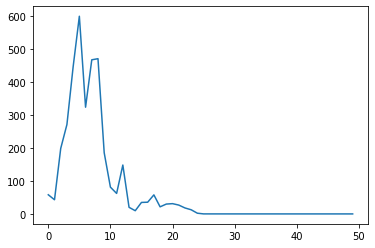

In [14]:
plt.plot(CE)
#plt.savefig("GD.png")

In [15]:
class LogisticRegression(object):
    def __init__(self, eta = 0.01, iteration = 2000):
        self.eta = eta
        self.iter = iteration
       
    def fit(self, x, t):
        self.w = np.zeros((10305, 5))
        bias = np.ones_like(train_2[:,0]).reshape(25, -1)
        x =  np.concatenate((bias, x), axis = 1)
        
        for _ in range(self.iter):            
            ak = x @ self.w
            y_p = np.exp(ak) / np.exp(ak).sum(axis = 1)[:, None]
            E_grad = x.T @ (y_p - t)
            self.w = self.w - self.eta * E_grad
        return self
    
    def predict(self, x):
        pass
    


## PCA

In [16]:
def eigen(train_x):
    cov_train = np.cov(train_x.T)
    eig_val, eig_vec = np.linalg.eig(cov_train)
    return eig_val, eig_vec

In [17]:
eig_val_train, eig_vec_train = eigen(train_2)

In [18]:
def PCA(train_x, n, eig_val_train, eig_vec_train):
    
    eig_pairs = [(np.abs(eig_val_train[i]), eig_vec_train[:,i]) for i in range(len(eig_val_train))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    tot = sum(eig_val_train[:n])
    var_exp = [(i / tot)*100 for i in sorted(eig_val_train[:n], reverse=True)]

    cum_var_exp = np.array(np.cumsum(var_exp), dtype = 'float32')

    pca_w = np.array([eig_pairs[i][1] for i in range(n)], dtype = 'float32')
    return train_x @ pca_w.T

In [19]:
pca_train_2 = PCA(train_2, 2, eig_val_train, eig_vec_train)
pca_train_5 = PCA(train_2, 5, eig_val_train, eig_vec_train)
pca_train_10 = PCA(train_2, 10, eig_val_train, eig_vec_train)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


In [20]:
pca_test_2 = PCA(test_2, 2, eig_val_train, eig_vec_train)
pca_test_5 = PCA(test_2, 5, eig_val_train, eig_vec_train)
pca_test_10 = PCA(test_2, 10, eig_val_train, eig_vec_train)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


In [37]:
w_IRLS_2, CE_IRLS_2 = logit(pca_train_2, train_t, 200, 'SGD')
w_IRLS_5, CE_IRLS_5 = logit(pca_train_5, train_t, 200, 'SGD')
w_IRLS_10, CE_IRLS_10 = logit(pca_train_10, train_t, 200, 'SGD')

In [38]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [39]:
y2 = predict(w_IRLS_2, pca_test_2, 'SGD')
print(np.argmax(y2, 1))

[0 1 0 0 0 1 1 1 1 1 2 2 2 2 2 2 0 2 1 1 0 1 1 0 0]


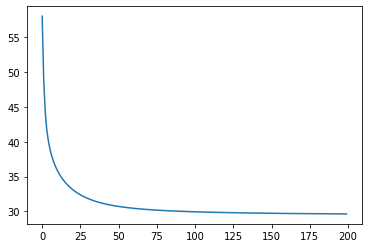

In [22]:
plt.plot(CE_IRLS_2)

In [40]:
y5 = predict(w_IRLS_5, pca_test_5, 'SGD')
print(np.argmax(y5, 1))

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4]


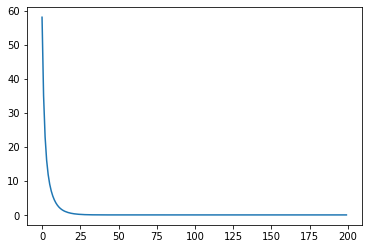

In [23]:
plt.plot(CE_IRLS_5)

In [41]:
y10 = predict(w_IRLS_10, pca_test_10, 'SGD')
print(np.argmax(y10, 1))

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4]


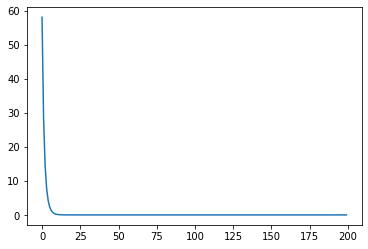

In [34]:
plt.plot(CE_IRLS_10)